In [1]:
# import tensorflow as tf
# from keras import backend as K

# num_cores = 4
# CPU = True
# GPU = False

# if GPU:
#     num_GPU = 1
#     num_CPU = 1
# if CPU:
#     num_CPU = 1
#     num_GPU = 0

# config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
#         inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
#         device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
# session = tf.Session(config=config)
# K.set_session(session)

Using TensorFlow backend.


In [7]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import *
import matplotlib.pyplot as plt
from tokenizer import tokenizer as tweet_tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import *
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import * 
from keras.regularizers import *
from keras.models import load_model
import pickle
import json
from keras.callbacks import ModelCheckpoint
from TP_transfer_learning_2018 import *
from TP_transfer_learning_2018.preprocessing import standardization


%matplotlib inline

PATH = './data'

path_train_3 = f'{PATH}/data_train_3.csv'
path_test_3 = f'{PATH}/data_test_3.csv'
path_train_7 = f'{PATH}/data_train_7.csv'
path_train_16m_3 = f'{PATH}/training.1600000.processed.noemoticon.csv'
path_dev_val = f'{PATH}/Valence_unprocessed/2018-Valence-oc-En-dev.csv'

# Serious business

## Preprocess

In [11]:
tweets = pd.read_csv(path_train_3, sep='\t', names=['ID', 'Class', 'Tweet'])
tweets_7 = pd.read_csv(path_train_7, sep='\t', names=['ID', 'Class', 'Tweet'], dtype={'Tweet': str})
tweets_3_test = pd.read_csv(path_test_3, sep='\t', names=['ID', 'Class', 'Tweet'], dtype={'Tweet': str})

tweets.shape, tweets_7.shape, tweets_3_test.shape

((50333, 3), (1630, 3), (1630, 3))

In [ ]:
tweets.sample(5)

In [31]:
tweets_7.head(5)

,ID,Class,Tweet
0,0,0,@liamch88 yeah! :) playing well
1,1,0,At least I don't have a guy trying to discoura...
2,2,0,UPLIFT: If you're still discouraged it means y...
3,3,0,"...at your age, the heyday in the blood is tam..."
4,4,-2,i was so embarrassed when she saw us i was lik...


In [20]:
tweets['Sentiment'] = tweets['Class'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x])
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: standardization(x))

In [14]:
tweets_7['Sentiment'] = tweets_7['Class'] + 3
tweets_7['Tweet'] = tweets_7['Tweet'].apply(lambda x: standardization(x))

In [15]:
tweets_7.head(5)

,ID,Class,Tweet,Sentiment
0,0,0,yeah playing well,3
1,1,0,least not guy try discourage anymore want neve...,3
2,2,0,uplift still discourage mean listen wrong voic...,3
3,3,0,... age heyday blood tame ...,3
4,4,-2,embarrass saw u like knvfkkjg think stalker n ...,1


In [33]:
tweets_3_test['Sentiment'] = tweets_3_test['Class'].apply(lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}[x])
tweets_3_test['Tweet'] = tweets_3_test['Tweet'].apply(lambda x: standardization(x))

In [34]:
display(tweets.sample(2))
display(tweets_7.head(2))
display(tweets_3_test.head(2))

,ID,Class,Tweet
28257,635721210806956032,neutral,For an art project in 7th grade we had to make...
17615,634516378268119041,negative,.@marklevinshow apparently Rick Perry is an id...


,ID,Class,Tweet,Sentiment
0,0,0,yeah ☺ ️ playing well,0
1,1,0,least not guy try discourage anymore want neve...,0


,ID,Class,Tweet,Sentiment
0,449,negative,site crash everytime try book help tell nothin...,0
1,450,negative,theme week ask lord strength perspective perse...,0


In [16]:
tweets_7.to_feather('pickles/train_7.feather')

In [36]:
tweets_3_test.to_feather('pickles/test_3.feather')

In [22]:
tweets.to_feather('pickles/train_3.feather')

## Training

In [108]:
tweets = pd.read_feather('pickles/train_3.feather')
test_3 = pd.read_feather('pickles/test_3.feather')
train_7 = pd.read_feather('pickles/train_7.feather')

train_x, train_y = tweets['Tweet'], tweets['Sentiment']
test_x, test_y = test_3['Tweet'], test_3['Sentiment']
train7_x, train7_y = train_7['Tweet'], train_7['Sentiment']

/home/epita/.local/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


* Fitting the tokenizer on our entire tweet base to make sure the indexes are rights

In [109]:
all_tweets = pd.concat([train_x, test_x, train7_x])
tokenizer = Tokenizer(filters=' ')
tokenizer.fit_on_texts(all_tweets)
word_index = tokenizer.word_index

pickle.dump(tokenizer, open("pickles/tokenizer.pickle", "wb"))

In [110]:
tokenizer = pickle.load(open("pickles/tokenizer.pickle", 'rb'))

* Looking for the MAX_SEQUENCE_LENGTH in all our sequences:

In [111]:
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)
train7_sequences = tokenizer.texts_to_sequences(train7_x)

sequences = train_sequences + test_sequences + train7_sequences
MAX_SEQUENCE_LENGTH = 0
for elt in sequences:
    if len(elt) > MAX_SEQUENCE_LENGTH:
        MAX_SEQUENCE_LENGTH = len(elt)

MAX_SEQUENCE_LENGTH

32

* We only train on train_3:

In [112]:
train_sequences = pad_sequences(train_sequences, MAX_SEQUENCE_LENGTH)
train_sequences.shape

(50333, 32)

#### Loading Datastories's embeddings

In [113]:
# googlenews_w2v = KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin', binary=True)
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile


tmp_file = get_tmpfile('datastories.300d.word2vec')
glove2word2vec('data/embeddings/datastories.twitter.300d.txt', tmp_file)
w2v = KeyedVectors.load_word2vec_format(tmp_file)

### EmoLex

In [114]:
emolex = pd.read_csv('TP_transfer_learning_2018/EmoLex.txt', sep='\t')

### OLE

In [115]:
positive_words = []
negative_words = []

with open('data/positive-words.txt') as positive_file, open('data/negative-words.txt', encoding='ISO-8859-1') as negative_file:
    for _ in range(35):
        next(positive_file)
        next(negative_file)
        
    for line in positive_file:
        positive_words.append(line)
    for line in negative_file:
        negative_words.append(line)

### Emoji valence and AFINN

In [116]:
afinn = pd.read_csv('data/AFINN-111.txt', sep='\t')

def val_to_list(x):
    x += 5
    return(to_categorical(x, num_classes=11, dtype='int'))


afinn[['val']] = afinn['val'].apply(val_to_list)
print(afinn.head(10))
print(afinn.loc[afinn['word'] == 'abandon'].val)

         word                                val
0     abandon  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
1   abandoned  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
2    abandons  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
3    abducted  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
4   abduction  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
5  abductions  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
6       abhor  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
7    abhorred  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
8   abhorrent  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
9      abhors  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
0    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Name: val, dtype: object


In [117]:
with open('./data/index.json') as emojiFile:
    emoji_valence = json.load(emojiFile)

for elmt in emoji_valence:
    val = elmt['polarity']
    elmt['polarity'] = val_to_list(val)
# emoji_valence

### Depeche Mood

In [118]:
DepecheMoodpp = pd.read_csv('data/DepecheMood/DepecheMood_english_token_full.tsv', sep='\t')
DepecheMood = pd.read_csv('data/DepecheMood/DepecheMood_freq.txt', sep='\t')

print(DepecheMood.columns.values)
print(DepecheMoodpp.columns.values)

['Lemma#PoS' 'AFRAID' 'AMUSED' 'ANGRY' 'ANNOYED' 'DONT_CARE' 'HAPPY'
 'INSPIRED' 'SAD']
['word' 'AFRAID' 'AMUSED' 'ANGRY' 'ANNOYED' 'DONT_CARE' 'HAPPY' 'INSPIRED'
 'SAD' 'freq']


### Embedding matrix

In [119]:
targets = to_categorical(train_y, 3)
nb_words = len(word_index) + 1

EMBEDDING_DIM = 300
EMOLEX_DIM = 10
OLE_DIM = 2
EMOJI_VALENCE_DIM = 11
AFINN_DIM = 11 
DEPECHE_MOOD_DIM = 8
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM + EMOLEX_DIM + OLE_DIM + AFINN_DIM + DEPECHE_MOOD_DIM + EMOJI_VALENCE_DIM))

oov = []  # Out of vocabulary
oov.append((np.random.rand(EMBEDDING_DIM) * 2.0) - 1.0)
oov = oov / np.linalg.norm(oov)
empty_afinn = np.full(11, 0)
empty_emoji = np.full(11, 0)
empty_emolex = np.full(10, 0)
empty_depeche = np.full(8, 0)


print(empty_emolex)
print(oov.shape)

for word, i in word_index.items():
    emoji_val = 0
    
    word_vector = oov
    if word in w2v.vocab:
        word_vector = w2v.word_vec(word)

    emolex_row = emolex.loc[emolex['word'] == word]
    if emolex_row.empty:
        word_vector = np.append(word_vector, empty_emolex)
    else:
        word_vector = np.append(word_vector, emolex_row.values.tolist()[0][1:])
        
    depeche_row = DepecheMoodpp.loc[DepecheMoodpp['word'] == word]
    if depeche_row.empty:
        word_vector = np.append(word_vector, empty_depeche)
    else:
        word_vector = np.append(word_vector, depeche_row.values.tolist()[0][1:9])
        
    ole_val = [0, 0]
    if word in positive_words:
        ole_val = [1, 0]
    elif word in negative_words:
        ole_val = [0, 1]
    word_vector = np.append(word_vector, ole_val)
    
    afinn_val = empty_afinn
    emoji_val = empty_emoji
    
    afinn_row = afinn.loc[afinn['word'] == word]
    if not afinn_row.empty:
        afinn_val = afinn_row['val'].item()
    else:
        for emoji in emoji_valence:
            if word == emoji['emoji']:
                emoji_val = emoji['polarity']

    word_vector = np.append(word_vector, afinn_val)
    
    word_vector = np.append(word_vector, emoji_val)
    
    embedding_matrix[i] = word_vector

        
print(embedding_matrix.shape)

[0 0 0 0 0 0 0 0 0 0]
(1, 300)
(37785, 342)


In [120]:
pickle.dump(embedding_matrix, open("pickles/embedding_matrix.pickle", "wb"))

In [121]:
# Claim memory back from this very large object we don't use anymore
del w2v

In [122]:
X_train, X_val, y_train, y_val = train_test_split(train_sequences, targets, test_size=0.3)

print('training set: ' + str(len(X_train)) + ' samples')
print('validation set: ' + str(len(X_val)) + ' samples')

print('x_train:', X_train.shape)
print('y_train:', y_train.shape)

training set: 35233 samples
validation set: 15100 samples
x_train: (35233, 32)
y_train: (35233, 3)


In [123]:
def model_2017():
    vocab_size = embedding_matrix.shape[0]
    embedding_size = embedding_matrix.shape[1]

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size, weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, trainable=False, name='embedding_layer'))
    model.add(GaussianNoise(0.3))
    # model.add(SpatialDropout1D(0.3))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(150, recurrent_dropout=0.3, return_sequences=True)))
    # model.add(Dropout(0.5))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(150, recurrent_dropout=0.3, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(3, activity_regularizer=l2(1e-4)))
    model.add(Activation('softmax'))

    # RMSprop or lr=1e-3
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-2), metrics=['acc'])

    print(model.summary())
    
    return model

def model_mine():
    vocab_size = embedding_matrix.shape[0]
    embedding_size = embedding_matrix.shape[1]

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size, weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, trainable=False, name='embedding_layer'))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    print(model.summary())
    
    return model

In [158]:
model = model_mine()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 342)           12922470  
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 342)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32, 300)           591600    
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 300)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32, 300)           541200    
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 300)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9600)              0         
__________

In [159]:
checkpoint_file = 'pickles/train3_weights-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)

In [160]:
model.fit(X_train, y_train, batch_size=128, validation_data=(X_val, y_val), callbacks=[checkpointer], epochs=5)

Train on 35233 samples, validate on 15100 samples
Epoch 1/5
35233/35233 [==============================] - 135s 4ms/step - loss: 0.8337 - acc: 0.5962 - val_loss: 0.7575 - val_acc: 0.6434

Epoch 00001: val_loss improved from inf to 0.75754, saving model to pickles/train3_weights-01-0.64.hdf5
Epoch 2/5
35233/35233 [==============================] - 126s 4ms/step - loss: 0.7653 - acc: 0.6402 - val_loss: 0.7406 - val_acc: 0.6593

Epoch 00002: val_loss improved from 0.75754 to 0.74058, saving model to pickles/train3_weights-02-0.66.hdf5
Epoch 3/5
35233/35233 [==============================] - 129s 4ms/step - loss: 0.7400 - acc: 0.6547 - val_loss: 0.7486 - val_acc: 0.6602

Epoch 00003: val_loss did not improve from 0.74058
Epoch 4/5
35233/35233 [==============================] - 128s 4ms/step - loss: 0.7173 - acc: 0.6691 - val_loss: 0.7265 - val_acc: 0.6619

Epoch 00004: val_loss improved from 0.74058 to 0.72648, saving model to pickles/train3_weights-04-0.66.hdf5
Epoch 5/5
35233/35233 [====

In [126]:
model.save('pickles/train_3_6668-mine.h5')

In [128]:
model = load_model('pickles/train_3_6668-mine.h5')

In [161]:
model.fit(X_train, y_train, batch_size=128, validation_data=(X_val, y_val), callbacks=[checkpointer], epochs=1)

Train on 35233 samples, validate on 15100 samples
Epoch 1/1
35233/35233 [==============================] - 126s 4ms/step - loss: 0.6723 - acc: 0.6951 - val_loss: 0.7369 - val_acc: 0.6613

Epoch 00001: val_loss did not improve from 0.72440


In [133]:
model.save('pickles/train_3_6715-mine.h5')

In [137]:
model = load_model('pickles/train_3_6715-mine.h5')

In [138]:
test_sequences = pad_sequences(test_sequences, MAX_SEQUENCE_LENGTH)
test_sequences.shape
Y_test = to_categorical(test_y, 3)

In [139]:
loss, acc = model.evaluate(test_sequences, Y_test, batch_size=128)

print(f'val_loss: {loss}\nval_acc: {acc}')

1630/1630 [==============================] - 3s 2ms/step
val_loss: 1.0251555976692153
val_acc: 0.5460122699386503


## Model evalutation

In [148]:
y_pred = np.argmax(model.predict(test_sequences, batch_size=128), axis=1)
y_true = test_y

In [150]:
y_pred.shape, test_y.shape

((1630,), (1630,))

In [151]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)
cm

array([[330, 248,  76],
       [ 85, 182, 179],
       [ 30, 122, 378]])

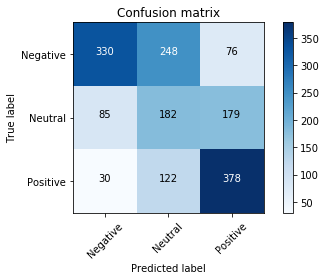

In [153]:
plot_confusion_matrix(cm, ['Negative', 'Neutral', 'Positive'])

Class,negative,neutral,positive
ID,7839,22591,19903
Tweet,7839,22591,19903
Sentiment,7839,22591,19903


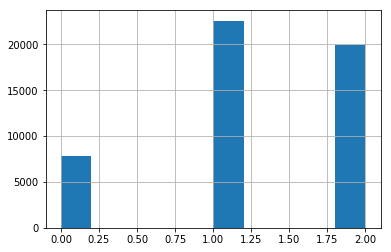

In [142]:
display(tweets.groupby('Class').count().T)
train_y.hist()

In [152]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Testing on dev set

In [3]:
val_dev = pd.read_csv(path_dev_val, sep='\t')

In [4]:
val_dev.head()

,ID,Tweet,Affect Dimension,Intensity Class
0,2018-En-02354,So @Ryanair site crashes everytime I try to bo...,valence,-3: very negative emotional state can be inferred
1,2018-En-00124,Theme of week: Ask the Lord for strength &amp;...,valence,-2: moderately negative emotional state can be...
2,2018-En-02603,"@F1 Why announcing so late, it will be hard to...",valence,-3: very negative emotional state can be inferred
3,2018-En-00450,The greatest happiness is seeing someone you l...,valence,3: very positive emotional state can be inferred
4,2018-En-00502,omg so grateful to have an education but ive b...,valence,1: slightly positive emotional state can be in...


In [5]:
val_dev['Intensity Class'].unique()

array(['-3: very negative emotional state can be inferred',
       '-2: moderately negative emotional state can be inferred',
       '3: very positive emotional state can be inferred',
       '1: slightly positive emotional state can be inferred',
       '2: moderately positive emotional state can be inferred',
       '-1: slightly negative emotional state can be inferred',
       '0: neutral or mixed emotional state can be inferred'],
      dtype=object)

In [8]:
seven_to_3 = {'-3: very negative emotional state can be inferred': 0,
              '-2: moderately negative emotional state can be inferred': 0,
              '-1: slightly negative emotional state can be inferred': 0,
              '3: very positive emotional state can be inferred': 2,
              '1: slightly positive emotional state can be inferred': 2,
              '2: moderately positive emotional state can be inferred': 2,
              '0: neutral or mixed emotional state can be inferred': 1}

seven_to_7 = {'-3: very negative emotional state can be inferred': -3,
              '-2: moderately negative emotional state can be inferred': -2,
              '-1: slightly negative emotional state can be inferred': -1,
              '3: very positive emotional state can be inferred': 3,
              '1: slightly positive emotional state can be inferred': 1,
              '2: moderately positive emotional state can be inferred': 2,
              '0: neutral or mixed emotional state can be inferred': 0}


val_dev['Sentiment'] = val_dev['Intensity Class'].apply(lambda x: seven_to_3[x])
val_dev['Target'] = val_dev['Intensity Class'].apply(lambda x: seven_to_7[x])
val_dev['Target_from_0'] = val_dev['Intensity Class'].apply(lambda x: seven_to_7[x] + 3)
val_dev['Tweet'] = val_dev['Tweet'].apply(lambda x: standardization(x))

In [10]:
val_dev.to_feather('pickles/dev_7.feather')

In [9]:
val_dev.head()

,ID,Tweet,Affect Dimension,Intensity Class,Sentiment,Target,Target_from_0
0,2018-En-02354,site crash everytime try book help tell nothin...,valence,-3: very negative emotional state can be inferred,0,-3,0
1,2018-En-00124,theme week ask lord strength perspective perse...,valence,-2: moderately negative emotional state can be...,0,-2,1
2,2018-En-02603,announce late hard make manchester organise day,valence,-3: very negative emotional state can be inferred,0,-3,0
3,2018-En-00450,greatest happiness see someone like stay happy...,valence,3: very positive emotional state can be inferred,2,3,6
4,2018-En-00502,omg grateful education ive back school two day...,valence,1: slightly positive emotional state can be in...,2,1,4


In [174]:
dev_x, dev_y = val_dev['Tweet'], val_dev['Sentiment']

dev_sequences = tokenizer.texts_to_sequences(dev_x)
dev_sequences = pad_sequences(dev_sequences, MAX_SEQUENCE_LENGTH)

In [176]:
y_pred = model.predict_classes(dev_sequences, batch_size=128)

In [177]:
cm = confusion_matrix(dev_y, y_pred)
cm

array([[104,  73,  21],
       [ 22,  47,  36],
       [  6,  41,  99]])

In [179]:
loss, acc = model.evaluate(dev_sequences, to_categorical(dev_y, 3), batch_size=128)

print(f'val_loss: {loss}\nval_acc: {acc}')

449/449 [==============================] - 1s 2ms/step
val_loss: 0.9411097316274665
val_acc: 0.5567928770337179
